In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload

time: 16.1 ms (started: 2025-12-05 14:24:28 -05:00)


In [2]:
import logging

# Set the logging level to INFO
logging.basicConfig(level=logging.INFO)

time: 411 µs (started: 2025-12-05 14:24:28 -05:00)


In [3]:
import os
from openai import OpenAI

 
client = OpenAI(
    api_key=os.environ["GEMINI_API_KEY"],
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

time: 152 ms (started: 2025-12-05 14:24:28 -05:00)


In [4]:
import json
import dataclasses

import py_trees
import arrow
from toolbox import Toolbox


# Clear the blackboard so we start fresh
py_trees.blackboard.Blackboard.clear()

blackboard = py_trees.blackboard.Client(name="Global")
blackboard.register_key(key="order", access=py_trees.common.Access.WRITE)
blackboard.order = []
blackboard.register_key(key="message_history", access=py_trees.common.Access.WRITE)
blackboard.message_history = []
blackboard.register_key(key="current_item", access=py_trees.common.Access.WRITE)
blackboard.current_item = None
blackboard.register_key(key="needs_customer_input", access=py_trees.common.Access.WRITE)
blackboard.needs_customer_input = False
blackboard.register_key(key="llm_job", access=py_trees.common.Access.WRITE)
blackboard.llm_job = None
blackboard.register_key(key="order_complete", access=py_trees.common.Access.WRITE)
blackboard.order_complete = False

time: 33.7 ms (started: 2025-12-05 14:24:28 -05:00)


In [5]:
import operator

from llm_node import LLMNode
from customer_input import CustomerInput
from complete_order import CompleteOrder
from ask_item import AskItem
from ask_how_many import AskHowMany
from ask_fries import AskFries
from ask_topping import AskTopping
from confirm_item import ConfirmItem


root = py_trees.composites.Selector(name="MainSequence", memory=False)


llm_jobs = py_trees.composites.Sequence("LLM Job", memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Has LLM Job?", py_trees.common.ComparisonExpression(
        variable="/llm_job",
        value=None,
        operator=operator.ne,
    )),
    LLMNode("LLM Job", client)
])

customer_input = py_trees.composites.Sequence("Customer Input", memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Needs Customer Input?", py_trees.common.ComparisonExpression(
        variable="/needs_customer_input",
        value=True,
        operator=operator.eq,
    )),
    CustomerInput("Ask Customer")
])

complete_order = py_trees.composites.Sequence("Complete Order", memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Has order items?", py_trees.common.ComparisonExpression(
        variable="/order",
        value=1,
        operator=lambda order, length: len(order) >= length,
    )),
    py_trees.behaviours.CheckBlackboardVariableValue("Not currently working on something?", py_trees.common.ComparisonExpression(
        variable="/current_item",
        value=None,
        operator=operator.eq,
    )),
    CompleteOrder("Confirm Order")
])

choose_item = py_trees.composites.Sequence("Choose Item", memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Needs current item?", py_trees.common.ComparisonExpression(
        variable="/current_item",
        value=None,
        operator=operator.eq,
    )),
    AskItem("Ask Item"),
])

customize_item = py_trees.composites.Selector('Customize Item', memory=False)
customize_chicken_nuggets = py_trees.composites.Sequence('Chicken Nuggets', memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Item is chicken nuggets?", py_trees.common.ComparisonExpression(
        variable="/current_item.name",
        value="chicken nuggets",
        operator=operator.eq
    )),
    py_trees.composites.Selector('How many?', memory=False, children=[
        py_trees.behaviours.CheckBlackboardVariableValue("Has Quantity?", py_trees.common.ComparisonExpression(
            variable="/current_item.quantity",
            value=None,
            operator=operator.ne
        )),
        AskHowMany("Ask how many?"),
    ]),
    py_trees.composites.Selector('With fries?', memory=False, children=[
        py_trees.behaviours.CheckBlackboardVariableValue("Has fries?", py_trees.common.ComparisonExpression(
            variable="/current_item.fries",
            value=None,
            operator=operator.ne
        )),
        AskFries("Do you want fries with that?"),
    ]),
])

def make_topping(name, topping):
    return py_trees.composites.Selector(f'With {topping}?', memory=False, children=[
        py_trees.behaviours.CheckBlackboardVariableValue(f"Has {topping}?", py_trees.common.ComparisonExpression(
            variable="/current_item",
            value=None,
            operator=lambda item, _: item.__dict__[topping] is not None
        )),
        AskTopping(name, topping),
    ])

customize_hamburger = py_trees.composites.Sequence('Hamburger', memory=False, children=[
    py_trees.behaviours.CheckBlackboardVariableValue("Item is hamburger?", py_trees.common.ComparisonExpression(
        variable="/current_item.name",
        value="hamburger",
        operator=operator.eq
    )),
    make_topping("Pickles?", "pickles"),
    make_topping("Lettuce?", "lettuce"),
    make_topping("Tomatoes?", "tomatoes"),
    py_trees.composites.Selector('With fries?', memory=False, children=[
        py_trees.behaviours.CheckBlackboardVariableValue("Has fries?", py_trees.common.ComparisonExpression(
            variable="/current_item.fries",
            value=None,
            operator=operator.ne
        )),
        AskFries("Do you want fries with that?"),
    ]),
])

customize_item.add_children([
    customize_chicken_nuggets,
    customize_hamburger,
])

confirm_item = ConfirmItem("Confirm Item")

build_item = py_trees.composites.Sequence("Build Item", memory=False, children=[
    customize_item,
    confirm_item,
])

ordering = py_trees.composites.Selector('Ordering', memory=False, children=[
    complete_order,
    choose_item,
    build_item,
])  

root.add_children([
    llm_jobs,
    customer_input,
    ordering,
])

root.setup()

time: 5.49 ms (started: 2025-12-05 14:24:28 -05:00)


In [6]:
from IPython.display import clear_output

def log_tree():
    print(py_trees.display.ascii_tree(root, show_status=True))
    print(py_trees.display.unicode_blackboard())

while not blackboard.order_complete:
    clear_output()
    for message in blackboard.message_history:
        print(f"{message['role']}: {message['content']}")
        
    for node in root.tick():
        #log_tree()
        pass

INFO:root:Saw update: LLM Job
INFO:root:[{'role': 'user', 'content': '\n\nYou are an order taker at a take out restaurant.\n\nThe customer is placing an order.\nThey\'ve just finished describing an item and adding it to their order.\nNow it\'s time to ask if they\'d like to order something else.\n\nThese are the items in their order:\n\n[\'{"name": "chicken nuggets", "quantity": 12, "fries": true}\', \'{"name": "hamburger", "fries": false, "pickles": true, "lettuce": true, "tomatoes": true}\']\n\nRead back their order, then ask them if they\'re finished or if there\'s something they\'d like to add.\nDon\'t suggest anything that is available to order with the "add_item" tool.\n\nIf they\'re good with their order, use the "complete_order" tool.\nIf they\'d like to add something to their order, use the "add_item" tool.\n\nMAKE SURE TO CONFIRM THE ENTIRE ORDER before using "complete_order".\n\nDON\'T ask any questions that you can\'t fulfill with the tools available to you.\n        \n\n--

assistant: Hello! Welcome to our takeout restaurant. What would you like to order today? We have chicken nuggets and hamburgers available.
user: chicken nuggets
assistant: Great choice! How many chicken nuggets would you like?
user: a dozen
assistant: Would you like fries with that?
user: yeeeeeah
assistant: So you'd like a dozen chicken nuggets with fries. Is there anything you'd like to change about this item?
user: nope
assistant: I have 12 chicken nuggets with fries added to your order. Would you like to add anything else, or is that everything for today?
user: burger
assistant: Would you like pickles on your hamburger?
user: yep
assistant: Would you like lettuce on your hamburger?
user: yep
assistant: Would you like tomatoes on your hamburger?
user: yep
assistant: Would you like fries with your hamburger?
user: no
assistant: So you'd like a hamburger with pickles, lettuce, and tomatoes, and no fries. Is there anything you'd like to change about this item?
user: looks good
assistan

INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"
INFO:toolbox.toolbox:Invoking tool: complete_order()


time: 2min 36s (started: 2025-12-05 14:24:28 -05:00)


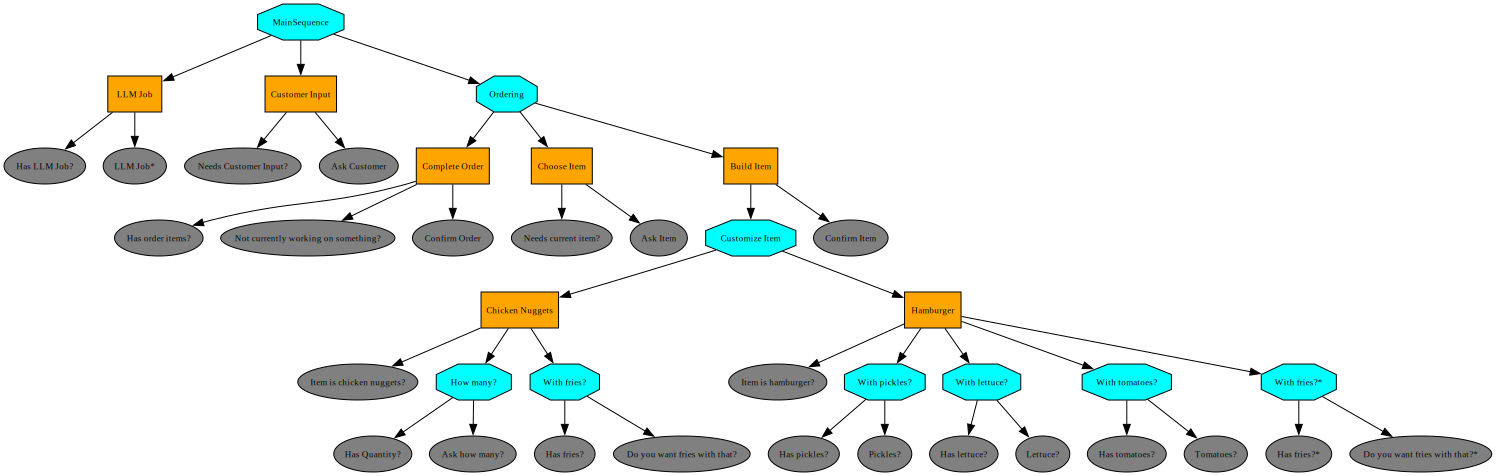

time: 292 ms (started: 2025-12-05 14:27:05 -05:00)


In [7]:
import pydot
from IPython.display import SVG

graph = py_trees.display.dot_tree(root)
SVG(graph.create_svg())

In [8]:
print(py_trees.display.ascii_tree(root, show_status=True))

[o] MainSequence [o]
    [-] LLM Job [o]
        --> Has LLM Job? [o] -- '/llm_job' comparison succeeded [v: LLMJob(system=None, user='\nYou are an order taker at a take out restaurant.\n\nThe customer is placing an order.\nThey\'ve just finished describing an item and adding it to their order.\nNow it\'s time to ask if they\'d like to order something else.\n\nThese are the items in their order:\n\n[\'{"name": "chicken nuggets", "quantity": 12, "fries": true}\', \'{"name": "hamburger", "fries": false, "pickles": true, "lettuce": true, "tomatoes": true}\']\n\nRead back their order, then ask them if they\'re finished or if there\'s something they\'d like to add.\nDon\'t suggest anything that is available to order with the "add_item" tool.\n\nIf they\'re good with their order, use the "complete_order" tool.\nIf they\'d like to add something to their order, use the "add_item" tool.\n\nMAKE SURE TO CONFIRM THE ENTIRE ORDER before using "complete_order".\n\nDON\'T ask any questions that you 

In [9]:
print(py_trees.display.unicode_blackboard())

Blackboard Data
    /current_item        : None
    /llm_job             : None
    /message_history     : [{'role': 'assistant', 'content': 'Hello! Welcome to our takeout restaurant. What would you like to order today? We have chicken nuggets and hamburgers available.'}, {'role': 'user', 'content': 'chicken nuggets'}, {'role': 'assistant', 'content': 'Great choice! How many chicken nuggets would you like?'}, {'role': 'user', 'content': 'a dozen'}, {'role': 'assistant', 'content': 'Would you like fries with that?'}, {'role': 'user', 'content': 'yeeeeeah'}, {'role': 'assistant', 'content': "So you'd like a dozen chicken nuggets with fries. Is there anything you'd like to change about this item?"}, {'role': 'user', 'content': 'nope'}, {'role': 'assistant', 'content': 'I have 12 chicken nuggets with fries added to your order. Would you like to add anything else, or is that everything for today?'}, {'role': 'user', 'content': 'burger'}, {'role': 'assistant', 'content': 'Would you like pick

In [10]:
from pprint import pprint

pprint(llm_jobs.children[1].last_message)

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='function-call-862948537018299049', function=Function(arguments='{}', name='complete_order'), type='function', extra_content={'google': {'thought_signature': 'Eq8UCqwUAXLI2nytmSfYi6KpO2UpkC3Qz5JabiX/ucKwg/RLS9oky8rhE/FCbTqh9LJrZSIvc7TcXL7RdaN5I8Hw86BQNKviVasW4rzTomUuPPQhFLOd8HmT0yzA7L8RoBLRcaaEdoXs0hHgT794HVGS+ntpDaEivfdfG5V5Z9yltAaGr3KvQEa6o/S8Sm9fZud1G8FvNNREsMLivfd+024bPNRGk3pjZhieA1yas/VpALo65ih9h0lF5NHkJ9MSCCCvMFp1ZXr8B0w5DUX9p4cMcHK+q6kcDO7JMdegiieqsQmqmhT5JlmepZ5MRRgNUAGpGhrcBRMzYSgXMBs1y5LBy1L6TQtvbrQY6mY7N9bmG6gcpe4AlsCae9GsWxXV+eRelUEzwagBW1WXmzWz88VX3yTfGeTeZFoDnu7v/yFPpFhwkXZLA2OTZ5HoFc4XWstllCdW4ymj/CXPsypJwsI8ZLR5ze94EHJFkoPOATKV2+3vb0o/+V4rwbt4djueJnzax7VTFC+932Fg0vszQPhs5S+egB02nEAi59+kqqsFWzDSHVedrEAuQCm/oRIcoJ7nCe7kkT+Q6HLr9/Kgda3WGmHvRLVHeW0U82k4d575R+f3Xq+WgD78Cnw7Brmw4O4UEhjzRhK1FoBrXZcWl4RdJApieD4mBuW1MtiG2nfTRfUN1ODTMVBghr8TRH+063/+wbXax/ZIwIhVcD

In [11]:
llm_jobs.children[1].jobs[-1]

LLMJob(system=None, user='\nYou are an order taker at a take out restaurant.\n\nThe customer is placing an order.\nThey\'ve just finished describing an item and adding it to their order.\nNow it\'s time to ask if they\'d like to order something else.\n\nThese are the items in their order:\n\n[\'{"name": "chicken nuggets", "quantity": 12, "fries": true}\', \'{"name": "hamburger", "fries": false, "pickles": true, "lettuce": true, "tomatoes": true}\']\n\nRead back their order, then ask them if they\'re finished or if there\'s something they\'d like to add.\nDon\'t suggest anything that is available to order with the "add_item" tool.\n\nIf they\'re good with their order, use the "complete_order" tool.\nIf they\'d like to add something to their order, use the "add_item" tool.\n\nMAKE SURE TO CONFIRM THE ENTIRE ORDER before using "complete_order".\n\nDON\'T ask any questions that you can\'t fulfill with the tools available to you.\n        ', toolbox=<toolbox.toolbox.Toolbox object at 0x1061

time: 1.22 ms (started: 2025-12-05 14:27:05 -05:00)


In [12]:
llm_jobs.children[1].jobs[-1].toolbox.execute(llm_jobs.children[1].last_message)

INFO:toolbox.toolbox:Invoking tool: complete_order()


({'role': 'assistant',
  'tool_calls': [{'id': 'function-call-862948537018299049',
    'function': {'arguments': '{}', 'name': 'complete_order'},
    'type': 'function',
    'extra_content': {'google': {'thought_signature': 'Eq8UCqwUAXLI2nytmSfYi6KpO2UpkC3Qz5JabiX/ucKwg/RLS9oky8rhE/FCbTqh9LJrZSIvc7TcXL7RdaN5I8Hw86BQNKviVasW4rzTomUuPPQhFLOd8HmT0yzA7L8RoBLRcaaEdoXs0hHgT794HVGS+ntpDaEivfdfG5V5Z9yltAaGr3KvQEa6o/S8Sm9fZud1G8FvNNREsMLivfd+024bPNRGk3pjZhieA1yas/VpALo65ih9h0lF5NHkJ9MSCCCvMFp1ZXr8B0w5DUX9p4cMcHK+q6kcDO7JMdegiieqsQmqmhT5JlmepZ5MRRgNUAGpGhrcBRMzYSgXMBs1y5LBy1L6TQtvbrQY6mY7N9bmG6gcpe4AlsCae9GsWxXV+eRelUEzwagBW1WXmzWz88VX3yTfGeTeZFoDnu7v/yFPpFhwkXZLA2OTZ5HoFc4XWstllCdW4ymj/CXPsypJwsI8ZLR5ze94EHJFkoPOATKV2+3vb0o/+V4rwbt4djueJnzax7VTFC+932Fg0vszQPhs5S+egB02nEAi59+kqqsFWzDSHVedrEAuQCm/oRIcoJ7nCe7kkT+Q6HLr9/Kgda3WGmHvRLVHeW0U82k4d575R+f3Xq+WgD78Cnw7Brmw4O4UEhjzRhK1FoBrXZcWl4RdJApieD4mBuW1MtiG2nfTRfUN1ODTMVBghr8TRH+063/+wbXax/ZIwIhVcDhzlIjRsMbIlgLwXRMeEPaIb4+R7CqW7y6+iu+JeWNMufbF/GL4BW9

time: 3.34 ms (started: 2025-12-05 14:27:05 -05:00)
